# Kuairec dataset
Source: https://kuairec.com/

In [1]:
# Change this line to read from desired file

In [2]:
import sys

In [27]:
path_to_experiment = "~/documents/low-rank-last-layer-inference/experiments/" # Change to path to experimetn
sys.path.append(path_to_experiment)

In [ ]:
cd "~/documents/KuaiRec 2.0"

In [5]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from functools import partial
from multiprocessing import Pool

In [6]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [7]:
sns.set_palette("colorblind")
plt.rcParams["figure.figsize"] = (7.2, 4.2)

In [8]:
%config InlineBackend.figure_format = "retina"

In [9]:
video_stats = pd.read_csv("./data/item_daily_features.csv")

# Shift features by one day
new_dates = pd.to_datetime(video_stats["date"].astype(str)) - pd.Timedelta(days=1)
video_stats["date"] = new_dates.apply(lambda x: int(x.strftime("%Y%m%d")))

In [10]:
target_cols = [
    "video_id", "date", "like_cnt", "share_cnt", "play_cnt", "comment_cnt",
    "complete_play_cnt", "follow_cnt", "reply_comment_cnt", "download_cnt",
]

cols_merge = ["video_id", "date"]
small_matrix = pd.read_csv("data/small_matrix.csv").dropna()
small_matrix = small_matrix.merge(video_stats[target_cols], on=cols_merge)
small_matrix.head()

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio,like_cnt,share_cnt,play_cnt,comment_cnt,complete_play_cnt,follow_cnt,reply_comment_cnt,download_cnt
0,14,148,4381,6067,2020-07-05 05:27:48.378,20200705.0,1.593898e+09,0.722103,3485,72,578125,626,406287,290,265,33
1,14,183,11635,6100,2020-07-05 05:28:00.057,20200705.0,1.593898e+09,1.907377,9478,67,481643,168,332326,355,45,31
2,14,3649,22422,10867,2020-07-05 05:29:09.479,20200705.0,1.593898e+09,2.063311,24073,807,1230980,462,796486,1174,33,308
3,14,5262,4479,7908,2020-07-05 05:30:43.285,20200705.0,1.593898e+09,0.566388,77044,500,1353520,1341,781144,5121,337,371
4,14,8234,4602,11000,2020-07-05 05:35:43.459,20200705.0,1.593899e+09,0.418364,6404,23,475632,339,262597,416,53,14


## Parse dataset

In [11]:
%%time
small_matrix_sub = small_matrix.dropna(subset="date")
small_matrix_sub = small_matrix_sub.assign(time=pd.to_datetime(small_matrix_sub["time"]))

unique_videos = small_matrix_sub["video_id"].unique()

# Encode new id for Embedding layer
id_to_ix_video = {id.item(): i for i, id in enumerate(unique_videos)}
small_matrix_sub = small_matrix_sub.assign(video_id=small_matrix_sub["video_id"].apply(lambda x: id_to_ix_video[x]))

CPU times: user 3.02 s, sys: 156 ms, total: 3.18 s
Wall time: 3.18 s


## Process dataset

In [12]:
def parse_batch_users(users, n_arms=5):
    df_batch = []
    for user in users:
        subset = small_matrix_sub.query("user_id == @user")
        n_values = len(subset)
        subset = subset.assign(group=np.arange(n_values) // n_arms)
        
        df_flat = subset.groupby("group").apply(lambda x: x.values.flatten(), include_groups=False).apply(pd.Series)
        df_flat.columns = [f"{col}_{i}" for i in range(n_arms) for col in subset.columns[:-1]]
        df_batch.append(df_flat)
    return df_batch

In [13]:
n_arms = 10
n_cores = os.cpu_count()
users = small_matrix_sub["user_id"].unique()
users_by_batch = np.array_split(users, n_cores)

In [19]:
%%time
poolfn = partial(parse_batch_users, n_arms=n_arms)
with Pool(n_cores) as pool:
    df_all = pool.map(poolfn, users_by_batch)
df_all = [element for batch in df_all for element in batch]
df_all = pd.concat(df_all, axis=0)
df_all.shape

CPU times: user 2.72 s, sys: 8.92 s, total: 11.6 s
Wall time: 15.7 s


(898878, 80)

In [ ]:
df_all.to_pickle(f"./data/arms_{n_arms:02}_raw.pkl")

# Processing data

In [14]:
import jax
import chex
import flax.linen as nn
import jax.numpy as jnp

In [15]:
n_arms = 10
size_experiment = 200_000

In [16]:
df_all = pd.read_pickle(f"./data/arms_{n_arms:02}_raw.pkl").dropna()
df_all = df_all.sort_values("time_0")
df_all = df_all.sample(frac=1.0, random_state=31, replace=False)

In [17]:
# We start by building a bandit problem where we are only given the possible arms to pull and the (latent) rewards
X = df_all[[c for c in df_all if ("video_id" in c)]]
Y = df_all[[c for c in df_all if "watch_ratio" in c]]
X.head()

,video_id_0,video_id_1,video_id_2,video_id_3,video_id_4,video_id_5,video_id_6,video_id_7,video_id_8,video_id_9
group,,,,,,,,,,
311,3196,3181.0,3097.0,3168.0,3204.0,3176.0,3177.0,3180.0,3197.0,3185.0
58,138,220.0,473.0,153.0,22.0,114.0,280.0,557.0,867.0,848.0
78,802,953.0,1144.0,777.0,2017.0,811.0,387.0,3318.0,923.0,1684.0
15,496,28.0,9.0,891.0,175.0,277.0,1285.0,19.0,193.0,447.0
301,3108,2248.0,3261.0,2615.0,2483.0,2496.0,3134.0,2468.0,3111.0,2842.0


In [18]:
X, Y = jax.tree.map(jnp.array, (X, Y))
n_obs = len(X)
n_obs

448552

In [19]:
n_videos = len(small_matrix_sub["video_id"].unique())

## Setup experiment

In [ ]:
import optax
from time import time
from functools import partial
from vbll_fifo import FifoLaplaceDiag
from bayes_opt import BayesianOptimization

In [29]:
import flax.linen as nn
from vbll_fifo import Regression, FifoVBLL, RegressionRefac
from bayesopt import test_functions, eval_fn, agents

In [30]:
from methods import low_rank_last_layer as hilofi
from methods import low_rank_filter_revised as lrkf
from methods import low_rank_filter as lofi

In [20]:
pd.set_option("display.width", 300)

In [21]:
target_cols = [
    "like_cnt", "share_cnt", "play_cnt", "comment_cnt",
    "complete_play_cnt", "follow_cnt", "reply_comment_cnt", "download_cnt",
]

In [22]:
def in_target_cols(column):
    return any([target_col in column for target_col in target_cols])

# We start by building a bandit problem where we are only given the possible arms to pull and the (latent) rewards
X = df_all[[c for c in df_all if ("video_id" in c) or in_target_cols(c)]]
Y = df_all[[c for c in df_all if "watch_ratio" in c]]

X, Y = jax.tree.map(jnp.array, (X, Y))
n_obs = len(X)

n_features = len(target_cols) + 1 # video id and like_cnt
X = X.reshape(-1, n_arms, n_features)

X = X.at[..., 1:].set(jnp.log1p(X[..., 1:]))

n_videos = len(small_matrix_sub["video_id"].unique())

In [23]:
class FeatureExtractor(nn.Module):
    n_videos: int
    embedding_dim: int
    dense_dim: int
    n_hidden: int

    @nn.compact
    def __call__(self, x):
        x_embedding = nn.Embed(self.n_videos, self.embedding_dim)(x[..., 0].astype(int))
        x_features = nn.Dense(self.dense_dim)(x[..., 1:])
        x = jnp.concat([x_embedding, x_features], axis=-1)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        return x


class MLP(nn.Module):
    n_videos: int
    embedding_dim: int
    dense_dim: int
    n_hidden: int

    @nn.compact
    def __call__(self, x):
        x = FeatureExtractor(self.n_videos, self.embedding_dim, self.dense_dim, self.n_hidden)(x)
        x = nn.Dense(1, name="last_layer")(x) # reward
        return x

## Run experiment

In [32]:
key = jax.random.PRNGKey(3141)
mlp = MLP(n_videos=n_videos, embedding_dim=10, dense_dim=10, n_hidden=50)
key_init, key_run = jax.random.split(key)
params_init = mlp.init(key_init, X[0, 0])    

In [33]:
def step(state, xs, agent):
    bel, key = state
    yt, xt = xs
    n_arms = xt.shape[0]
    key_sample, key_update = jax.random.split(key, 2)

    bel = agent.predict(bel)

    keys_sample = jax.random.split(key_sample, n_arms)
    rewards_est = jax.vmap(agent.sample_predictive, in_axes=(0, None, 0))(keys_sample, bel, xt)
    
    # Choose the arm to pull
    arm = rewards_est.argmax()
    
    reward_obs = yt[arm]
    x_pulled = xt[arm]

    bel_update = agent.update(bel, reward_obs, x_pulled)
    state_update = (bel_update, key_update)
    return state_update, reward_obs

## HiLoFi

In [34]:
def cov_fn(y): return jnp.eye(1) * 1e-4
agent = hilofi.LowRankLastLayer(
    mlp.apply, cov_fn, rank=20, dynamics_hidden=0.0, dynamics_last=0.0
)

bel_init = agent.init_bel(params_init, cov_hidden=1.0, cov_last=1.0, low_rank_diag=True)
state_init = (bel_init, key_run)
XS = (jnp.log1p(Y[:size_experiment]), X[:size_experiment])
_step = partial(step, agent=agent)
time_init = time()
(bel_final, _), rewards_hilofi = jax.lax.scan(_step, state_init, XS)
rewards_hilofi = np.exp(np.array(rewards_hilofi)) - 1
time_end = time()

time_hilofi = time_end - time_init
print(rewards_hilofi.sum())
print(f"Running time {time_hilofi:.2f}", end=2*"\n")

244288.39
Running time 70.65



## Laplace

In [35]:
def maximise_laplace(lr, noise):
    def lossfn(params, counter, x, y, apply_fn, noise=noise):
        res = apply_fn(params, x).squeeze()
        logprobas = jax.scipy.stats.norm.logpdf(res.squeeze(), y.squeeze(), noise)
        loss = - (logprobas * counter).sum() / counter.sum()
        return loss.squeeze()

    
    agent = FifoLaplaceDiag(
        mlp.apply,
        lossfn,
        tx=optax.adam(lr),
        buffer_size=buffer_size,
        dim_features=X.shape[-1],
        dim_output=1,
        n_inner=n_inner,
    )
    
    bel_init = agent.init_bel(params_init)
    state_init = (bel_init, key_run)
    XS = (jnp.log1p(Y[:10_000]), X[:10_000])
    _step = partial(step, agent=agent)
    (bel_final, _), rewards_laplace = jax.lax.scan(§_step, state_init, XS)
    rewards_laplace = np.exp(np.array(rewards_laplace)) - 1
    return rewards_laplace.sum()

In [66]:
pbounds = {
    "lr": [1e-6, 1e-2],
    "noise": [1e-7, 2],
}

bo = BayesianOptimization(maximise_laplace, pbounds=pbounds)
bo.maximize()

|   iter    |  target   |    lr     |   noise   |
-------------------------------------------------
| 1         | 9.508e+03 | 0.007251  | 1.935     |
| 2         | 9.22e+03  | 0.002699  | 0.4034    |
| 3         | 9.334e+03 | 0.009368  | 0.1225    |
| 4         | 9.308e+03 | 0.002561  | 1.484     |
| 5         | 9.576e+03 | 0.00793   | 0.333     |
| 6         | 9.307e+03 | 0.006499  | 0.06504   |
| 7         | 9.31e+03  | 0.006325  | 0.3234    |
| 8         | 9.22e+03  | 0.0005494 | 1.53      |
| 9         | 9.378e+03 | 0.007354  | 0.145     |
| 10        | 9.394e+03 | 0.003315  | 1.484     |
| 11        | 9.415e+03 | 0.007336  | 0.1449    |
| 12        | 9.343e+03 | 0.003405  | 0.1785    |
| 13        | 9.192e+03 | 0.008739  | 0.3334    |
| 14        | 9.275e+03 | 0.006578  | 0.6367    |
| 15        | 9.338e+03 | 0.006986  | 1.934     |
| 16        | 9.129e+03 | 0.003263  | 1.484     |
| 17        | 9.322e+03 | 0.008977  | 0.7084    |
| 18        | 9.123e+03 | 0.007102  | 1.935     |


In [36]:
def lossfn(params, counter, x, y, apply_fn, noise=0.1):
    res = apply_fn(params, x).squeeze()
    logprobas = jax.scipy.stats.norm.logpdf(res.squeeze(), y.squeeze(), noise)
    loss = - (logprobas * counter).sum() / counter.sum()
    return loss.squeeze()

learning_rate = 1e-4
# learning_rate = 0.008322
buffer_size = 10
n_inner = 50
agent = FifoLaplaceDiag(
    mlp.apply,
    cov_fn,
    lossfn,
    tx=optax.adamw(learning_rate),
    buffer_size=buffer_size,
    dim_features=X.shape[-1],
    dim_output=1,
    n_inner=n_inner,
)

bel_init = agent.init_bel(params_init)
state_init = (bel_init, key_run)
XS = (jnp.log1p(Y[:size_experiment]), X[:size_experiment])
_step = partial(step, agent=agent)
time_init = time()
(bel_final, _), rewards_laplace = jax.lax.scan(_step, state_init, XS)
rewards_laplace = np.exp(np.array(rewards_laplace)) - 1
time_end = time()

time_laplace = time_end - time_init
print(rewards_laplace.sum())
print(f"Running time {time_laplace:.2f}", end=2*"\n")

175648.77
Running time 330.84



## LRKF

In [37]:
%%time
def cov_fn(y): return jnp.eye(1) * 1e-2
agent = lrkf.LowRankCovarianceFilter(mlp.apply, cov_fn, dynamics_covariance=1e-6, rank=20)

bel_init = agent.init_bel(params_init, cov=1.0)
state_init = (bel_init, key_run)
XS = (jnp.log1p(Y[:size_experiment]), X[:size_experiment])
_step = partial(step, agent=agent)

time_init = time()
(bel_final, _), rewards_lrkf = jax.lax.scan(_step, state_init, XS)
rewards_lrkf = np.exp(np.array(rewards_lrkf)) - 1
time_end = time()

time_lrkf = time_end - time_init
print(rewards_lrkf.sum())
print(f"Running time {time_lrkf:.2f}", end=2*"\n")

220972.53
Running time 66.07

CPU times: user 9.16 s, sys: 299 ms, total: 9.46 s
Wall time: 1min 6s


## LoFi

In [84]:
def maximise_lofi(cov_init, dynamics, noise):
    def cov_fn(y): return jnp.eye(1) * noise
    agent = lofi.LowRankPrecisionFilter(mlp.apply, cov_fn, dynamics_covariance=dynamics, rank=20)
    
    bel_init = agent.init_bel(params_init, cov=cov_init)
    state_init = (bel_init, key_run)
    XS = (jnp.log1p(Y[:10_000]), X[:10_000])
    _step = partial(step, agent=agent)
    (bel_final, _), rewards_lofi = jax.lax.scan(_step, state_init, XS)
    rewards_lofi = np.exp(np.array(rewards_lofi)) - 1
    return rewards_lofi.sum()

pbounds = {
    "dynamics": [1e-7, 1.0],
    "cov_init": [1e-6, 1.0],
    "noise": [1e-7, 2],
}

bo = BayesianOptimization(maximise_lofi, pbounds=pbounds)
bo.maximize()

|   iter    |  target   | cov_init  | dynamics  |   noise   |
-------------------------------------------------------------
| 1         | 9.322e+03 | 0.02724   | 0.8347    | 0.2435    |
| 2         | 9.318e+03 | 0.3679    | 0.6243    | 0.7814    |
| 3         | 9.321e+03 | 0.2562    | 0.171     | 0.7472    |
| 4         | 9.321e+03 | 0.8515    | 0.3459    | 0.5101    |
| 5         | 9.315e+03 | 0.6813    | 0.09932   | 1.699     |
| 6         | 9.322e+03 | 0.8595    | 0.8918    | 0.8771    |
| 7         | 9.324e+03 | 0.8084    | 0.8366    | 0.9559    |
| 8         | 9.318e+03 | 0.8092    | 0.9       | 1.177     |
| 9         | 9.322e+03 | 0.8112    | 0.7496    | 0.868     |
| 10        | 9.318e+03 | 0.6787    | 0.9103    | 0.9172    |
| 11        | 9.318e+03 | 0.01318   | 0.4313    | 0.3168    |
| 12        | 9.319e+03 | 0.535     | 0.3559    | 1.624     |
| 13        | 9.323e+03 | 0.8564    | 0.7661    | 0.9624    |
| 14        | 9.32e+03  | 0.8466    | 0.8861    | 0.8766    |
| 15    

In [ ]:
%%time
def cov_fn(y): return jnp.eye(1) * 0.1
agent = lofi.LowRankPrecisionFilter(mlp.apply, cov_fn, dynamics_covariance=1e-6, rank=50)

bel_init = agent.init_bel(params_init, cov=0.1)
state_init = (bel_init, key_run)
XS = (jnp.log1p(Y[:size_experiment]), X[:size_experiment])
# XS = (jnp.log1p(Y[:100]), X[:100])
_step = partial(step, agent=agent)

time_init = time()
(bel_final, _), rewards_lofi = jax.lax.scan(_step, state_init, XS)
rewards_lofi = np.exp(np.array(rewards_lofi)) - 1
time_end = time()

time_lofi = time_end - time_init
print(rewards_lofi.sum())
print(f"Running time {time_lofi:.2f}", end=2*"\n")

## VBLL

In [ ]:
class VBLLMLP(nn.Module):
    n_videos: int
    embedding_dim: int
    dense_dim: int
    n_hidden: int
    wishart_scale: float = 0.01
    regularization_weight: float = 1.0


    @nn.compact
    def __call__(self, x):
        x = FeatureExtractor(self.n_videos, self.embedding_dim, self.dense_dim, self.n_hidden)(x)
        x = Regression(
            in_features=self.n_hidden, out_features=1,
            wishart_scale=self.wishart_scale,
            regularization_weight=self.regularization_weight,
            name="last_layer",
        )(x)
        return x

In [ ]:
dim = X.shape[-1]

buffer_size = 10
n_inner = 50

In [ ]:
def maximise_vbll(lr, regw, wscale):
    vbl_mlp = VBLLMLP(
        n_videos=n_videos, embedding_dim=10, n_hidden=50, dense_dim=10,
        regularization_weight=regw, wishart_scale=wscale
    )
    params_init_vbll = vbl_mlp.init(key_init, X[0,0])
    
    def lossfn(params, counter, x, y, apply_fn):
        res = apply_fn(params, x)
        return res.train_loss_fn(y, counter)
    
    agent = FifoVBLL(
        vbl_mlp.apply,
        lossfn,
        tx=optax.adamw(lr),
        buffer_size=buffer_size,
        dim_features=dim,
        dim_output=1,
        n_inner=n_inner,
    )

    bel_init = agent.init_bel(params_init_vbll)
    
    state_init = (bel_init, key_run)
    XS = (jnp.log1p(Y[:10_000]), X[:10_000])
    _step = partial(step, agent=agent)
    (bel_final, _), rewards_vbll_fifo = jax.lax.scan(_step, state_init, XS)
    rewards_vbll_fifo = np.exp(np.array(rewards_vbll_fifo)) - 1

    return rewards_vbll_fifo.sum()

In [ ]:
pbounds = {
    "lr": [1e-7, 0.99],
    "regw": [0.0, 1],
    "wscale": [0.0, 1]
}

bo = BayesianOptimization(maximise_vbll, pbounds=pbounds)
bo.maximize()

In [ ]:
learning_rate = 1e-3
# learning_rate = 0.9714
# regw = 0.5587
# wscale = 0.6762
buffer_size = 10
n_inner = 50
vbl_mlp = VBLLMLP(
    n_videos=n_videos, embedding_dim=10, n_hidden=50, dense_dim=10,
    regularization_weight=0.0,
)
params_init_vbll = vbl_mlp.init(key_init, X[0,0])

def lossfn(params, counter, x, y, apply_fn):
    res = apply_fn(params, x)
    return res.train_loss_fn(y, counter)

dim = X.shape[-1]

agent = FifoVBLL(
    vbl_mlp.apply,
    lossfn,
    tx=optax.adamw(learning_rate),
    buffer_size=buffer_size,
    dim_features=dim,
    dim_output=1,
    n_inner=n_inner,
)

In [ ]:
%%time
print("Running agent with VBLL")
bel_init = agent.init_bel(params_init_vbll)

state_init = (bel_init, key_run)
XS = (jnp.log1p(Y[:size_experiment]), X[:size_experiment])
_step = partial(step, agent=agent)
time_init = time()
(bel_final, _), rewards_vbll_greedy = jax.lax.scan(_step, state_init, XS)
rewards_vbll_greedy = np.exp(np.array(rewards_vbll_greedy)) - 1
time_end = time()

time_vbll_greedy = time_end - time_init
print(rewards_vbll_greedy.sum())
print(f"Running time {time_vbll_greedy:0.2f}")

## VBLL full

In [ ]:
learning_rate = 1e-3
buffer_size = 1000
n_inner = 100
vbl_mlp = VBLLMLP(
    n_videos=n_videos, embedding_dim=10, n_hidden=50, dense_dim=10,
    regularization_weight=1/1000,
)
params_init_vbll = vbl_mlp.init(key_init, X[0,0])

def lossfn(params, counter, x, y, apply_fn):
    res = apply_fn(params, x)
    return res.train_loss_fn(y, counter)

dim = X.shape[-1]

agent = FifoVBLL(
    vbl_mlp.apply,
    lossfn,
    tx=optax.adamw(learning_rate),
    buffer_size=buffer_size,
    dim_features=dim,
    dim_output=1,
    n_inner=n_inner,
)

In [ ]:
%%time
print("Running agent with VBLL")
bel_init = agent.init_bel(params_init_vbll)

time_init = time()
state_init = (bel_init, key_run)
XS = (jnp.log1p(Y[:size_experiment]), X[:size_experiment])
_step = partial(step, agent=agent)
(bel_final, _), rewards_vbll_long = jax.lax.scan(_step, state_init, XS)
time_init = time()
rewards_vbll_long = np.exp(np.array(rewards_vbll_long)) - 1
time_end = time()

time_vbll_long = time_end - time_init
print(rewards_vbll_long.sum())
print(f"Running time {time_vbll_long:0.2f}")

## Results

In [48]:
index = df_all["time_0"][:size_experiment]
rewards = {
    "HiLoFi": rewards_hilofi,
    "OnVBLL": rewards_vbll_greedy,
    "VBLL": rewards_vbll_long,
    "LRKF": rewards_lrkf,
    "LoFi": rewards_lofi,
    "LLL": rewards_laplace,
}
rewards = pd.DataFrame(rewards, index=index)

In [49]:
times = {
    "HiLoFi": time_hilofi,
    "OnVBLL": time_vbll_greedy,
    "VBLL": time_vbll_long,
    "LRKF": time_lrkf,
    "LoFi": time_lofi,
    "LLL": time_laplace
}

In [50]:
result = {
    "rewards": rewards,
    "times": times
}

In [78]:
result = jax.tree.map(np.array, result)
pd.to_pickle(result, "./kuairek.pkl")

## Load data

In [51]:
oracle_reward = pd.Series(Y[:size_experiment].max(axis=1), index=index)

In [52]:
methods = ["HiLoFi", "OnVBLL", "VBLL", "LRKF", "LoFi", "LLL"]

In [81]:
result = pd.read_pickle("./kuairek.pkl")

In [53]:
map_methods = {method: method for method in methods}

In [54]:
times = pd.Series(result["times"]).astype(float)
times = times.rename(map_methods)

In [55]:
rewards = result["rewards"]
rewards = pd.DataFrame(rewards, index=index, columns=methods)

In [56]:
rewards = rewards.rename(map_methods, axis=1)
rewards = rewards.sort_index(axis=1)

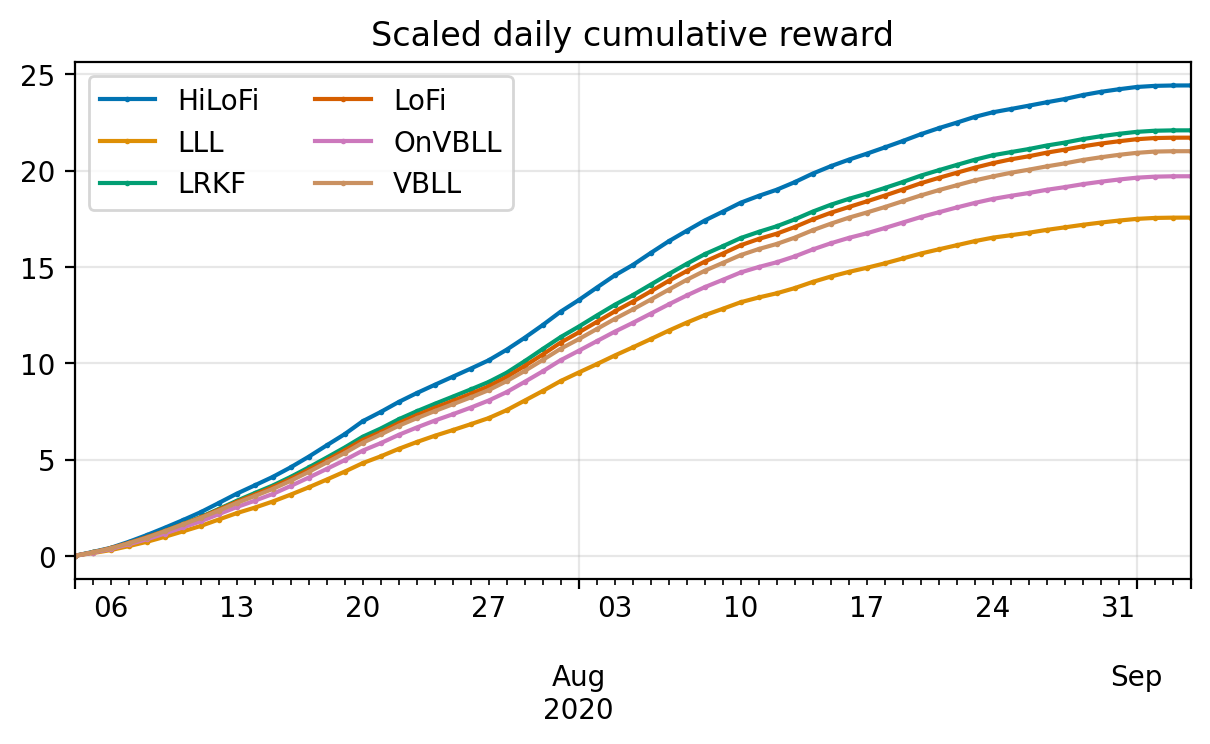

In [57]:
fig, ax = plt.subplots(figsize=(7.2, 4.2 * 0.8))
(rewards / 1e4).resample("D").sum().cumsum().plot(marker="o", markersize=1, ax=ax)
plt.title("Scaled daily cumulative reward")
plt.grid(alpha=0.3)
plt.legend(ncol=2)
plt.xlabel("")
plt.savefig("bandits-daily-cumulative-reward.png", dpi=300, bbox_inches="tight");

In [58]:
pd.Series(times).sort_index().astype(float)

HiLoFi      70.652515
LLL        330.835162
LRKF        66.065707
LoFi       165.995334
OnVBLL     682.298933
VBLL      1620.639955
dtype: float64

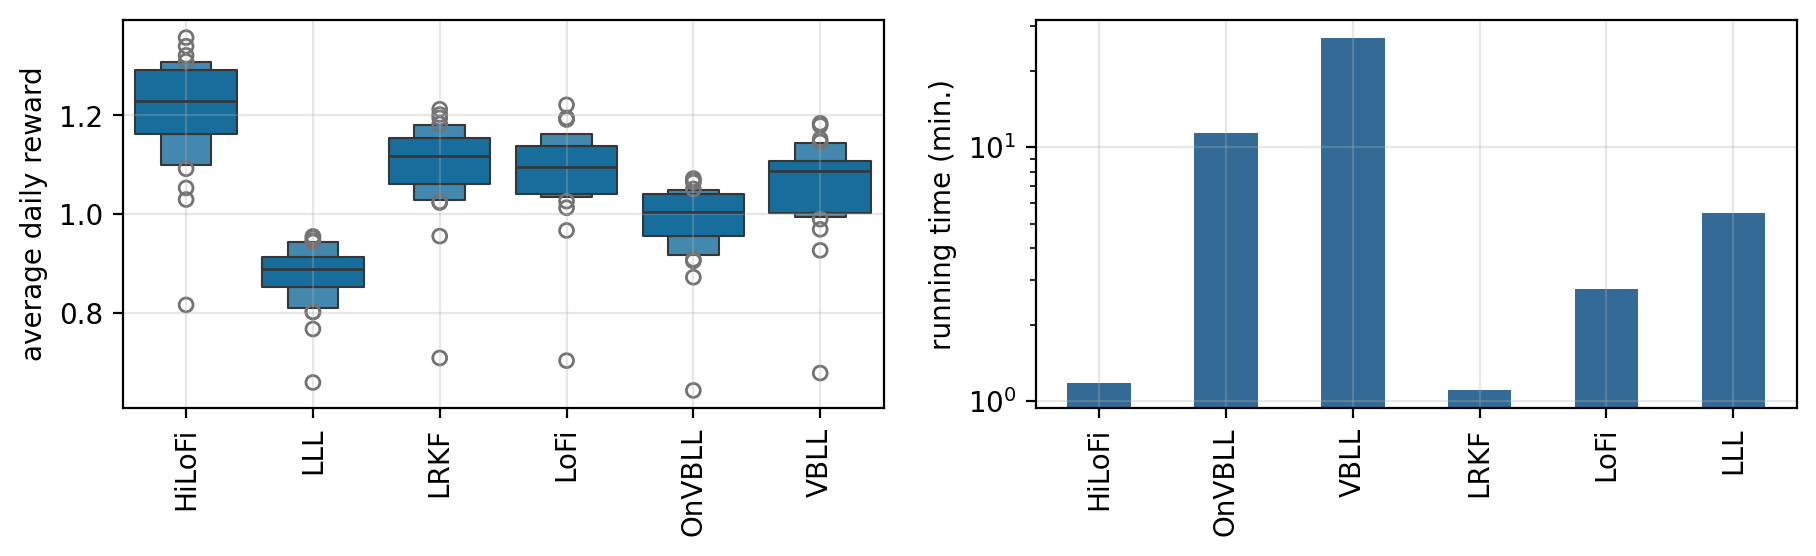

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(7.2 * 1.5, 4.2 * 0.6))
sns.boxenplot(
    x="variable",
    y="value",
    data=rewards.resample("2D").mean().melt(),
    ax=ax[0]
)
plt.sca(ax[0])
ax[0].set_ylabel("average daily reward")
ax[0].set_xlabel("")
ax[0].grid(alpha=0.3)
plt.xticks(rotation=90)

(times.astype(float)/60.0).plot(kind="bar", ax=ax[1], color="#336a96")
ax[1].grid(alpha=0.3)
ax[1].set_ylabel("running time (min.)")
ax[1].set_yscale("log")
# plt.savefig("bandits-average-daily-reward.png", dpi=300, bbox_inches="tight")

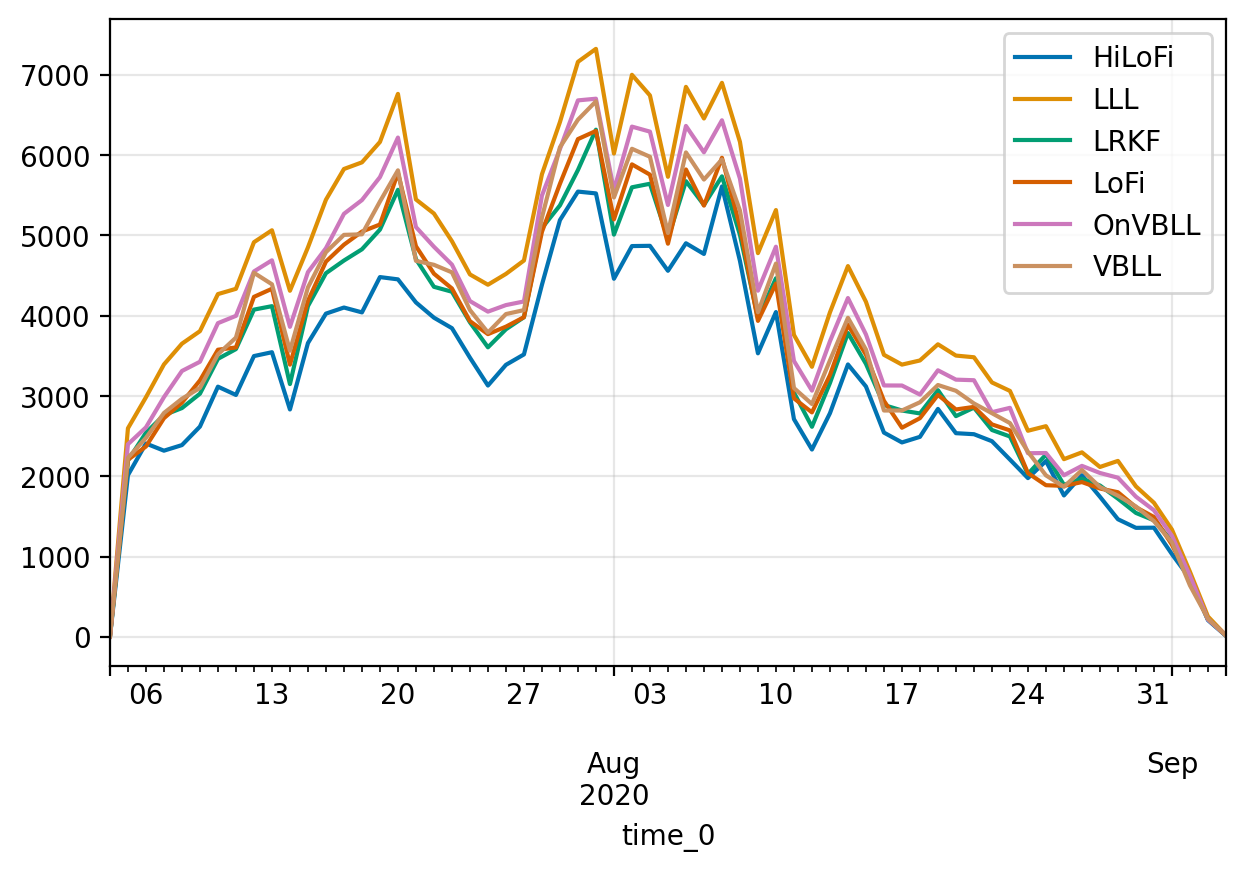

In [62]:
regret = -rewards.resample("D").sum().sub(oracle_reward.resample("D").sum(), axis=0)
regret.plot()
plt.grid(alpha=0.3)

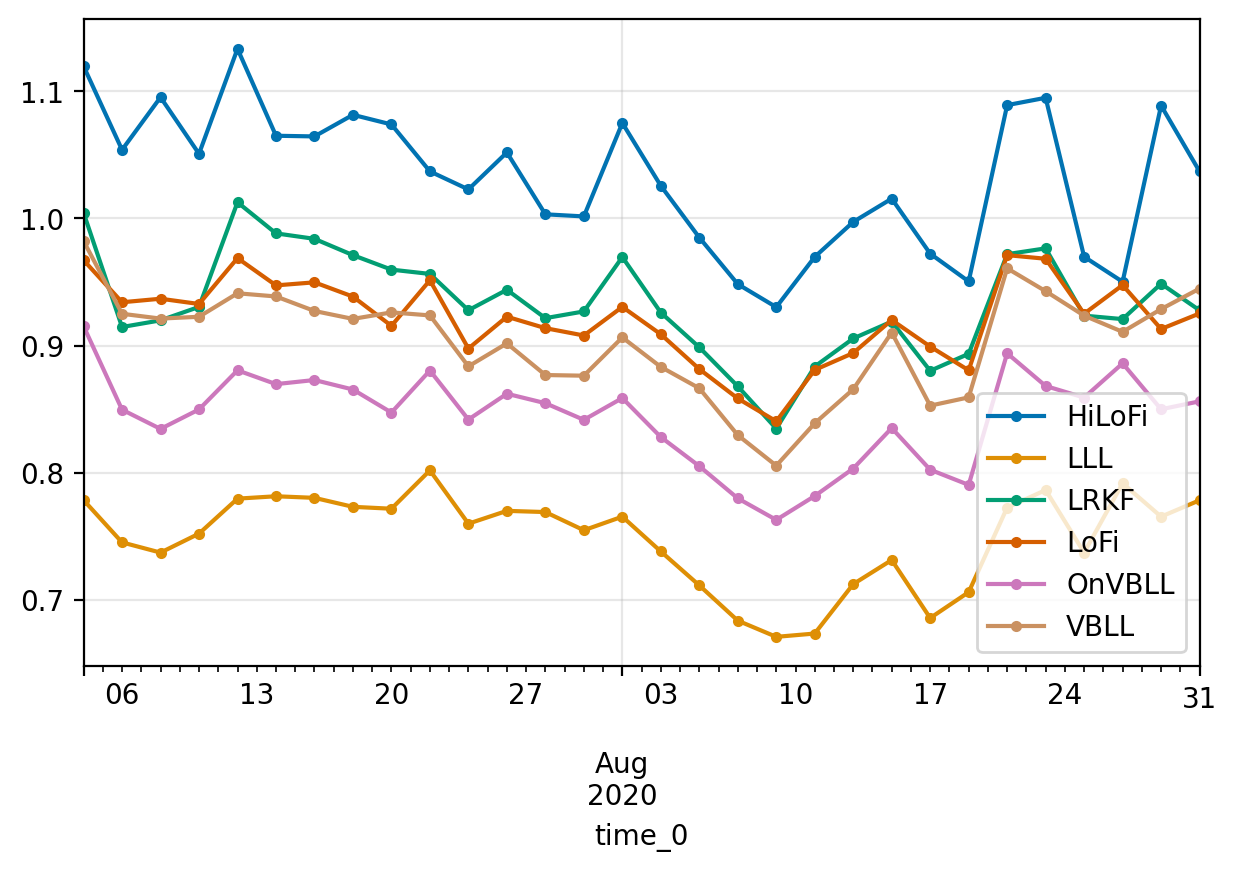

In [61]:
rewards.resample("2D").median().iloc[:-2].plot(marker="o", markersize=3)
plt.grid(alpha=0.3)